# Noise from data, SEM-bad fit

From sklearn.gaussianprocess.GaussianProcessRegressor 

'alpha- If an array is passed, it must have the same number of entries as the data used for fitting and is used as datapoint-dependent noise level'

In [601]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, WhiteKernel, Exponentiation,ExpSineSquared,ConstantKernel as C
from sklearn.gaussian_process.kernels import PairwiseKernel,RationalQuadratic
from sklearn.metrics import mean_squared_error
import joblib
from datetime import datetime, timedelta

# Read data
df = pd.read_csv(r'Weekly_Average_FoodWaste_with_SEM_v2.csv')

# Convert 'Date' to datetime format
df['Date'] = pd.to_datetime(df['Date'])

#The dataframe got NaN in SEM. Replace with zero
df[['Carbohydrates_sem','Fiber_sem','Protein_sem','Fat_sem']] = df[['Carbohydrates_sem','Fiber_sem','Protein_sem','Fat_sem']].fillna(0) 

# Create explicit max and min of error bar by adding SEM
df['Carb_sem_max'] = df['Carbohydrates_avg'] + df['Carbohydrates_sem']
df['Carb_sem_min'] = df['Carbohydrates_avg'] - df['Carbohydrates_sem']


df.head()




,Date,Carbohydrates_avg,Fiber_avg,Protein_avg,Fat_avg,Carbohydrates_sem,Fiber_sem,Protein_sem,Fat_sem,Carb_sem_max,Carb_sem_min
0,2023-01-08,670.82,0.00,97.90,127.36,88.34,0.00,52.38,71.41,759.16,582.48
1,2023-01-15,618.12,5.38,20.76,27.83,324.87,3.65,7.38,21.42,942.99,293.25
2,2023-01-22,1204.24,8.48,167.34,232.78,433.66,8.11,38.57,95.84,1637.90,770.58
3,2023-01-29,87.83,0.00,318.67,1542.42,0.00,0.00,0.00,0.00,87.83,87.83
4,2023-02-05,307.26,15.11,43.99,72.72,61.91,6.52,11.81,31.67,369.17,245.35


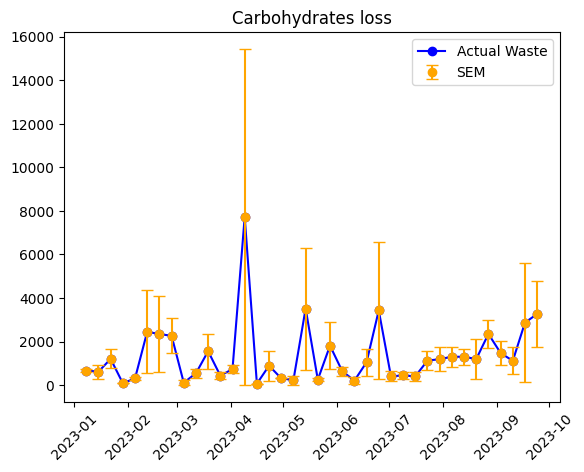

In [602]:

plt.plot(df['Date'], df['Carbohydrates_avg'], label='Actual Waste', color='blue', marker='o')
# Plot Standard Error of the Mean (SEM) as points
plt.errorbar(df['Date'], df['Carbohydrates_avg'], yerr=df['Carbohydrates_sem'], fmt='o', label='SEM', color='orange', ecolor='orange', capsize=4)
plt.xticks(rotation=45)
plt.title(f'Carbohydrates loss')
plt.legend()

Xshape:(37, 1), yshape:(37, 1), semshape:(37,)


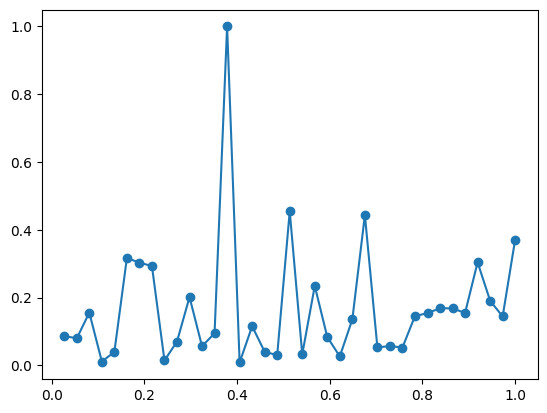

In [603]:

# Define the chosen category for plotting
chosen_category = 'Carbohydrates'
chosen_sem = chosen_category+'_sem'
chosen_category = chosen_category+'_avg'

# Filter the data for the chosen category
selected_columns = ['Date', chosen_category]
filtered_data = df[selected_columns]

split_ratio = 0.97 # 0.93 = 2 points (test data)
split_index = int(len(filtered_data) * split_ratio)
df_train = filtered_data[:split_index+1]
df_test = filtered_data[split_index:]


# Set Standard Error data

filtered_sem = df[[chosen_sem,'Carb_sem_max','Carb_sem_min']]
df_sem_train = filtered_sem[:split_index+1]

sem = df_sem_train[chosen_sem].to_numpy()

start = filtered_data['Date'].min()
end = filtered_data['Date'].max()
range_datetime = (end - start).days

# Normalize date and waste variables
reference_date = datetime(2023, 1, 1)

#Shah added
normalized_date_full = (df['Date'] - reference_date).dt.days.values.reshape(-1, 1) / range_datetime

normalized_date = (df_train['Date'] - reference_date).dt.days.values.reshape(-1, 1) / range_datetime
normalized_waste = df_train[chosen_category].values.reshape(-1, 1) / np.max(filtered_data[chosen_category])
X = normalized_date
y = normalized_waste    

# Normalize date and waste variables
normalized_date_range = (df_test['Date'] - reference_date).dt.days.values.reshape(-1, 1) / range_datetime
normalized_waste_range = df_test[chosen_category].values.reshape(-1, 1) / np.max(df_train[chosen_category])

X_train_ =  normalized_date
X_test_ =  normalized_date_range

## Check fit data shape



print(f'Xshape:{X.shape}, yshape:{y.shape}, semshape:{sem.shape}')
#print(f'{type(X)}, {type(y)}, {type(sem)}')
plt.plot(X,y,marker='o')


kernel is  RBF(length_scale=13.9) + Matern(length_scale=28.1, nu=5)


 c:\Users\shahr\code\.mlenv\Lib\site-packages\sklearn\gaussian_process\_gpr.py:475: UserWarning:Predicted variances smaller than 0. Setting those variances to 0.


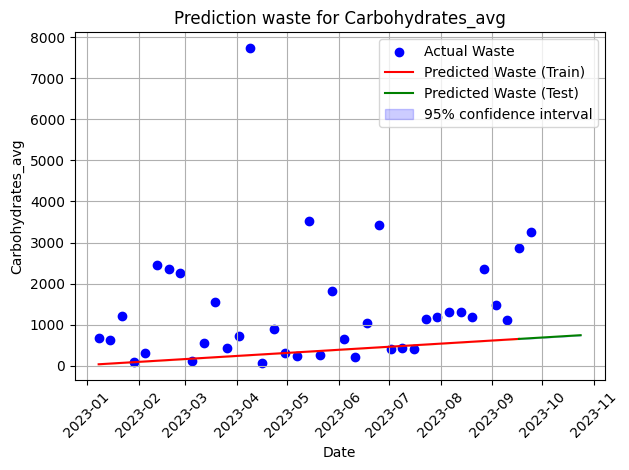

In [604]:
#------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Gaussian stuff starts here 

# Define different kernels
#kernel_rbf = RBF(length_scale=20 ) #+ WhiteKernel(noise_level=10)
#kernel_matern = Matern(length_scale=2.4, nu=5 ) #length_scale=2, nu=1.05, sigma=1 / length_scale=2.4, nu=1.03, sigma=2 / length_scale=2.4, nu=5 , split = 0.97
#kernel_combined = kernel_rbf + kernel_matern

# Shah-change here
kernel_rbf =  RBF(length_scale=1)
kernel_b = ExpSineSquared(length_scale=1)
kernel_b = RationalQuadratic(length_scale=1)
kernel_b = Matern(length_scale=2.4, nu=5 ) #length_scale=2, nu=1.05, sigma=1 / length_scale=2.4, nu=1.03, sigma=2 / length_scale=2.4, nu=5 , split = 0.97

kernel_combined = kernel_rbf + kernel_b

# Shah -added SEM here
# Create Gaussian Process with different kernels
model = GaussianProcessRegressor(kernel=kernel_combined, n_restarts_optimizer=10,alpha=sem)

# Fit the Gaussian Processes for the current category
model.fit(X, y)
model_params = model.get_params()

print('kernel is ',model.kernel_)

#prediction for train data
start_date = df_train['Date'].min()
end_date =   df_train['Date'].max() 
date_train = pd.date_range(start=start_date, end=end_date, freq='D')

# Normalize the date range
normalized_date_train = (date_train - reference_date).days / range_datetime
X_train = normalized_date_train.values.reshape(-1, 1)

#---------------------------------------------------------------------------
# Make predictions for the date range using the GP model
y_pred_train, sigma_range_train = model.predict(X_train, return_std=True)

# Denormalize the predicted wastes
predicted_waste_train = y_pred_train * np.max(filtered_data[chosen_category])

###predict for test data
start_dates = df_test['Date'].min()
end_dates =   df_test['Date'].max()+ timedelta(days=30)
date_test = pd.date_range(start=start_dates, end=end_dates, freq='D')

# Normalize the date range
normalized_date_test = (date_test - reference_date).days / range_datetime
X_test = normalized_date_test.values.reshape(-1, 1)

# Make predictions for the date range using the GP model
y_pred_test, sigma_range_test = model.predict(X_test, return_std=True)

# Denormalize the predicted wastes
predicted_waste_test = y_pred_test * np.max(filtered_data[chosen_category])

#Set the confidence interval (shah)
#w = 2
w = 2
alpha = 0.2 #0.2

# Visualization
#plt.plot(filtered_data['Date'], filtered_data[chosen_category], marker='o' ,c='blue', label='Actual Waste')
plt.scatter(filtered_data['Date'], filtered_data[chosen_category],c='blue', label='Actual Waste')
plt.plot(date_train, predicted_waste_train, 'r', label='Predicted Waste (Train)')
plt.plot(date_test, predicted_waste_test, c='green', markersize=8, label='Predicted Waste (Test)')
plt.fill_between(
    date_train.ravel(),
    predicted_waste_train - w * sigma_range_train, 
    predicted_waste_train + w * sigma_range_train, 
    alpha=alpha, 
    color='y')
plt.fill_between(
    date_test.ravel(),
    predicted_waste_test - w * sigma_range_test, 
    predicted_waste_test + w * sigma_range_test, 
    alpha=alpha,
    color='b',
    label=r"95% confidence interval")
plt.xlabel('Date')
plt.ylabel(chosen_category)
plt.title(f'Prediction waste for {chosen_category}')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


# GP_extras -our data

## Dependencies and load data

In [605]:
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C
from sklearn.cluster import KMeans

# Read data
df = pd.read_csv(r'Weekly_Average_FoodWaste_with_SEM_v2.csv')

# Convert 'Date' to datetime format
df['Date'] = pd.to_datetime(df['Date'])

#The dataframe got NaN in SEM. Replace with zero
df[['Carbohydrates_sem','Fiber_sem','Protein_sem','Fat_sem']] = df[['Carbohydrates_sem','Fiber_sem','Protein_sem','Fat_sem']].fillna(0) 



df.head()


,Date,Carbohydrates_avg,Fiber_avg,Protein_avg,Fat_avg,Carbohydrates_sem,Fiber_sem,Protein_sem,Fat_sem
0,2023-01-08,670.82,0.00,97.90,127.36,88.34,0.00,52.38,71.41
1,2023-01-15,618.12,5.38,20.76,27.83,324.87,3.65,7.38,21.42
2,2023-01-22,1204.24,8.48,167.34,232.78,433.66,8.11,38.57,95.84
3,2023-01-29,87.83,0.00,318.67,1542.42,0.00,0.00,0.00,0.00
4,2023-02-05,307.26,15.11,43.99,72.72,61.91,6.52,11.81,31.67


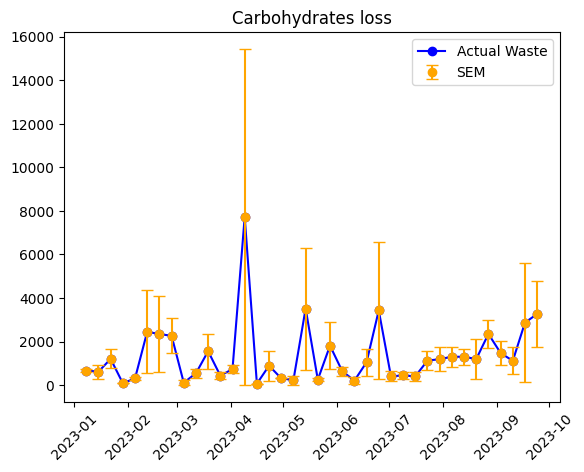

In [606]:

plt.plot(df['Date'], df['Carbohydrates_avg'], label='Actual Waste', color='blue', marker='o')
# Plot Standard Error of the Mean (SEM) as points
plt.errorbar(df['Date'], df['Carbohydrates_avg'], yerr=df['Carbohydrates_sem'], fmt='o', label='SEM', color='orange', ecolor='orange', capsize=4)
plt.xticks(rotation=45)
plt.title(f'Carbohydrates loss')
plt.legend()

## Set X,y and prototypes

(37, 1)
<class 'numpy.ndarray'>


 c:\Users\shahr\code\.mlenv\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


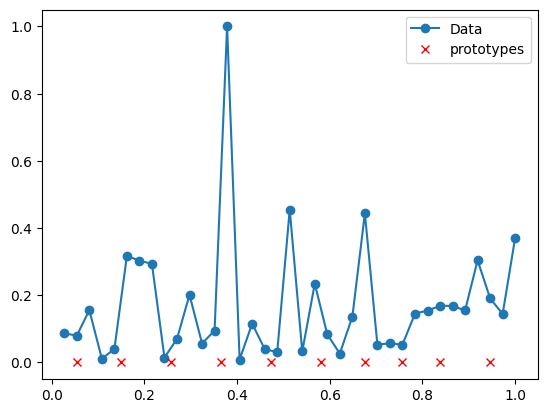

In [607]:

# Define the chosen category for plotting
chosen_category = 'Carbohydrates'
chosen_category = chosen_category+'_avg'

# Filter the data for the chosen category
selected_columns = ['Date', chosen_category]
filtered_data = df[selected_columns]

split_ratio = 0.97 # 0.93 = 2 points (test data)
split_index = int(len(filtered_data) * split_ratio)
df_train = filtered_data[:split_index+1]
df_test = filtered_data[split_index:]

start = filtered_data['Date'].min()
end = filtered_data['Date'].max()
range_datetime = (end - start).days

# Normalize date and waste variables
reference_date = datetime(2023, 1, 1)
normalized_date = (df_train['Date'] - reference_date).dt.days.values.reshape(-1, 1) / range_datetime
normalized_waste = df_train[chosen_category].values.reshape(-1, 1) / np.max(filtered_data[chosen_category])
X = normalized_date
y = normalized_waste    

# Normalize date and waste variables
normalized_date_range = (df_test['Date'] - reference_date).dt.days.values.reshape(-1, 1) / range_datetime
normalized_waste_range = df_test[chosen_category].values.reshape(-1, 1) / np.max(df_train[chosen_category])

X_train_ =  normalized_date
X_test_ =  normalized_date_range

print(X.shape)
print(type(X))

#-----------------------------------------------------------------------------------------
# HETEROSCEDASTIC starts here
Xproto = X.squeeze()
prototypes = KMeans(n_clusters=10).fit(Xproto[:, np.newaxis]).cluster_centers_
plt.plot(X,y,marker='o')
plt.plot(prototypes,np.zeros_like(prototypes),'x', color='red')
plt.legend(['Data','prototypes'])
plt.show()

## Heteroscedastic Kernel Class

In [608]:
from sklearn.gaussian_process.kernels import Kernel, _approx_fprime, Hyperparameter, RBF, pairwise_kernels

class HeteroscedasticKernel(Kernel):

    """Kernel which learns a heteroscedastic noise model.

    This kernel learns for a set of prototypes values from the data space
    explicit noise levels. These exemplary noise levels are then generalized to
    the entire data space by means for kernel regression.

    Parameters
    ----------
    prototypes : array-like, shape = (n_prototypes, n_X_dims)
        Prototypic samples from the data space for which noise levels are
        estimated.

    sigma_2 : float, default: 1.0
        Parameter controlling the initial noise level

    sigma_2_bounds : pair of floats >= 0, default: (0.1, 10.0)
        The lower and upper bound on sigma_2

    gamma : float, default: 1.0
        Length scale of the kernel regression on the noise level

    gamma_bounds : pair of floats >= 0, default: (1e-2, 1e2)
        The lower and upper bound on gamma
    """
    def __init__(self, prototypes, sigma_2=1.0, sigma_2_bounds=(0.1, 10.0),
                 gamma=1.0, gamma_bounds=(1e-2, 1e2)):
        assert prototypes.shape[0] == sigma_2.shape[0]
        self.prototypes = prototypes

        self.sigma_2 = np.asarray(sigma_2)
        self.sigma_2_bounds = sigma_2_bounds

        self.gamma = gamma
        self.gamma_bounds = gamma_bounds

        self.hyperparameter_sigma_2 = \
                Hyperparameter("sigma_2", "numeric", self.sigma_2_bounds,
                               self.sigma_2.shape[0])

        self.hyperparameter_gamma = \
                Hyperparameter("gamma", "numeric", self.gamma_bounds)

    @classmethod
    def construct(cls, prototypes, sigma_2=1.0, sigma_2_bounds=(0.1, 10.0),
                  gamma=1.0, gamma_bounds=(1e-2, 1e2)):
        prototypes = np.asarray(prototypes)
        if prototypes.shape[0] > 1 and len(np.atleast_1d(sigma_2)) == 1:
            sigma_2 = np.repeat(sigma_2, prototypes.shape[0])
            sigma_2_bounds = np.vstack([sigma_2_bounds] *prototypes.shape[0])
        return cls(prototypes, sigma_2, sigma_2_bounds, gamma, gamma_bounds)

    def __call__(self, X, Y=None, eval_gradient=False):
        """Return the kernel k(X, Y) and optionally its gradient.

        Parameters
        ----------
        X : array, shape (n_samples_X, n_features)
            Left argument of the returned kernel k(X, Y)

        Y : array, shape (n_samples_Y, n_features), (optional, default=None)
            Right argument of the returned kernel k(X, Y). If None, k(X, X)
            if evaluated instead.

        eval_gradient : bool (optional, default=False)
            Determines whether the gradient with respect to the kernel
            hyperparameter is determined. Only supported when Y is None.

        Returns
        -------
        K : array, shape (n_samples_X, n_samples_Y)
            Kernel k(X, Y)

        K_gradient : array (opt.), shape (n_samples_X, n_samples_X, n_dims)
            The gradient of the kernel k(X, X) with respect to the
            hyperparameter of the kernel. Only returned when eval_gradient
            is True.
        """
        prototypes_std = self.prototypes.std(0)
        n_prototypes = self.prototypes.shape[0]
        n_gradient_dim = \
            n_prototypes + (0 if self.hyperparameter_gamma.fixed else 1)

        X = np.atleast_2d(X)
        if Y is not None and eval_gradient:
            raise ValueError("Gradient can only be evaluated when Y is None.")

        if Y is None:
            K= np.eye(X.shape[0]) * self.diag(X)
            if eval_gradient:
                K_gradient = \
                    np.zeros((K.shape[0], K.shape[0], n_gradient_dim))
                K_pairwise = \
                    pairwise_kernels(self.prototypes / prototypes_std,
                                     X / prototypes_std,
                                     metric="rbf", gamma=self.gamma)
                for i in range(n_prototypes):
                    for j in range(K.shape[0]):
                        K_gradient[j, j, i] = \
                            self.sigma_2[i] * K_pairwise[i, j] \
                            / K_pairwise[:, j].sum()
                if not self.hyperparameter_gamma.fixed:
                    # XXX: Analytic expression for gradient?
                    def f(gamma):  # helper function
                        theta = self.theta.copy()
                        theta[-1] = gamma[0]
                        return self.clone_with_theta(theta)(X, Y)
                    K_gradient[:, :, -1] = \
                        _approx_fprime([self.theta[-1]], f, 1e-5)[:, :, 0]
                return K, K_gradient
            else:
                return K
        else:
            K = np.zeros((X.shape[0], Y.shape[0]))
            return K   # XXX: similar entries?

    def is_stationary(self):
        """Returns whether the kernel is stationary. """
        return False

    def diag(self, X):
        """Returns the diagonal of the kernel k(X, X).

        The result of this method is identical to np.diag(self(X)); however,
        it can be evaluated more efficiently since only the diagonal is
        evaluated.

        Parameters
        ----------
        X : array, shape (n_samples_X, n_features)
            Left argument of the returned kernel k(X, Y)

        Returns
        -------
        K_diag : array, shape (n_samples_X,)
            Diagonal of kernel k(X, X)
        """
        prototypes_std = self.prototypes.std(0)
        n_prototypes = self.prototypes.shape[0]

        # kernel regression of noise levels
        K_pairwise = \
            pairwise_kernels(self.prototypes / prototypes_std,
                             X / prototypes_std,
                             metric="rbf", gamma=self.gamma)

        return (K_pairwise * self.sigma_2[:, None]).sum(axis=0) \
                / K_pairwise.sum(axis=0)

    def __repr__(self):
        return "{0}(sigma_2=[{1}], gamma={2})".format(self.__class__.__name__,
            ", ".join(map("{0:.3g}".format, self.sigma_2)), self.gamma)

## Fit

In [609]:
#kernel_hetero = C(1.0, (1e-10, 1000)) * RBF(1, (0.01, 100.0)) \
#    + HeteroscedasticKernel.construct(prototypes, 1e-3, (1e-10, 50.0),
#                                      gamma=5.0, gamma_bounds="fixed")

#kernel_hetero =  C(1.0, (1e-10, 1000)) * RBF(length_scale=20) + Matern(length_scale=2.4,nu=5) \
#    + HeteroscedasticKernel.construct(prototypes, 1e-3, (1e-10, 50.0), gamma=5.0, gamma_bounds="fixed")


kernel_hetero = RBF(length_scale=20) + Matern(length_scale=2.4,nu=5) 

gp_heteroscedastic = GaussianProcessRegressor(kernel=kernel_hetero,n_restarts_optimizer=10)

#gp_heteroscedastic.fit(X[:, np.newaxis], y)
gp_heteroscedastic.fit(X, y)
print(f"Heteroscedastic kernel: {gp_heteroscedastic.kernel_}")
print(f"Heteroscedastic LML: {gp_heteroscedastic.log_marginal_likelihood(gp_heteroscedastic.kernel_.theta)}")


 c:\Users\shahr\code\.mlenv\Lib\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning:lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


Heteroscedastic kernel: RBF(length_scale=9.01e+04) + Matern(length_scale=0.0389, nu=5)
Heteroscedastic LML: -22.71539798696118


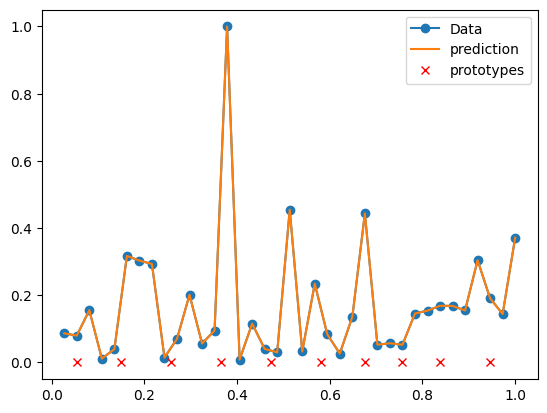

In [610]:
y_mean, y_std = gp_heteroscedastic.predict(X, return_std=True)
#plt.plot(X_, y_mean, 'k', lw=3, zorder=9, label="predicted mean")


plt.plot(X,y,marker='o',label='Data')
plt.plot(X,y_mean,label='Fit')
plt.plot(prototypes,np.zeros_like(prototypes),'x', color='red')
plt.legend(['Data','prediction','prototypes'])
plt.show()

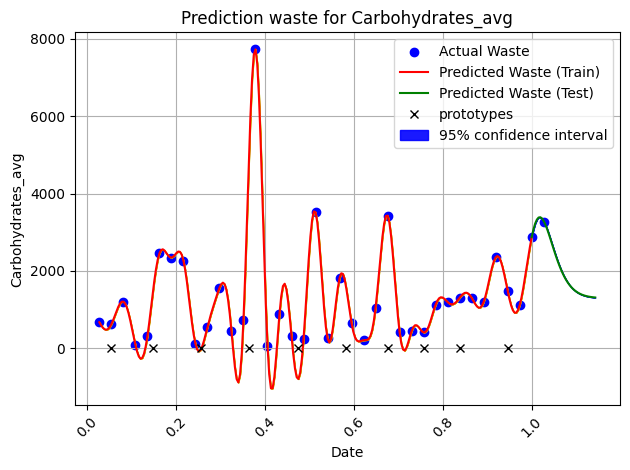

In [611]:
#prediction for train data
start_date = df_train['Date'].min()
end_date =   df_train['Date'].max() 
date_train = pd.date_range(start=start_date, end=end_date, freq='D')

# Normalize the date range
normalized_date_train = (date_train - reference_date).days / range_datetime
X_train = normalized_date_train.values.reshape(-1, 1)

#---------------------------------------------------------------------------
# Make predictions for the date range using the GP model
y_pred_train, sigma_range_train = gp_heteroscedastic.predict(X_train, return_std=True)

# Denormalize the predicted wastes
predicted_waste_train = y_pred_train * np.max(filtered_data[chosen_category])

###predict for test data
start_dates = df_test['Date'].min()
end_dates =   df_test['Date'].max()+ timedelta(days=30)
date_test = pd.date_range(start=start_dates, end=end_dates, freq='D')

# Normalize the date range
normalized_date_test = (date_test - reference_date).days / range_datetime
X_test = normalized_date_test.values.reshape(-1, 1)

# Make predictions for the date range using the GP model
y_pred_test, sigma_range_test = gp_heteroscedastic.predict(X_test, return_std=True)

# Denormalize the predicted wastes
predicted_waste_test = y_pred_test * np.max(filtered_data[chosen_category])

#Set the confidence interval (shah)
#w = 2
w = 2
alpha = 0.9 #0.2

# Visualization
#plt.plot(filtered_data['Date'], filtered_data[chosen_category], marker='o' ,c='blue', label='Actual Waste')
plt.scatter(normalized_date_full, filtered_data[chosen_category],c='blue', label='Actual Waste')
#plt.plot(date_train, predicted_waste_train, 'r', label='Predicted Waste (Train)')
plt.plot(normalized_date_train, predicted_waste_train, 'r', label='Predicted Waste (Train)')
#plt.plot(date_test, predicted_waste_test, c='green', markersize=8, label='Predicted Waste (Test)')
plt.plot(normalized_date_test, predicted_waste_test, c='green', markersize=8, label='Predicted Waste (Test)')

plt.plot(prototypes,np.zeros_like(prototypes),'x', color='black',label='prototypes')
plt.fill_between(
    #date_train.ravel(),
    normalized_date_train,
    predicted_waste_train - w * sigma_range_train, 
    predicted_waste_train + w * sigma_range_train, 
    alpha=alpha, 
    color='y')
plt.fill_between(
    #date_test.ravel(),
    normalized_date_test,
    predicted_waste_test - w * sigma_range_test, 
    predicted_waste_test + w * sigma_range_test, 
    alpha=alpha,
    color='b',
    label=r"95% confidence interval")

plt.xlabel('Date')
plt.ylabel(chosen_category)
plt.title(f'Prediction waste for {chosen_category}')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

## Check array shape

In [612]:
#normalized_date.shape

print(predicted_waste_train.shape)
print(date_train.shape)
print(normalized_date_train.shape)

print('---')
print(filtered_data[chosen_category].shape)
print(date_test.shape)
print(normalized_date_test.shape)


print('---')
print(normalized_date_range.shape)
print(normalized_date.shape)
print(normalized_waste.shape)
print(normalized_waste_range.shape)

(253,)
(253,)
(253,)
---
(38,)
(38,)
(38,)
---
(2, 1)
(37, 1)
(37, 1)
(2, 1)
